# BT2101 Introduction to Decision Tree

## 1 Goal

In this notebook, we will explore **Decision Tree** including:
* User-defined functions
* Open-source package: `scikit-learn`

For the **Decision Tree** method, you will:
* Use numpy to write functions
* Write binary recursive splitting functions
* Write decision functions
* Write pruning functions
* Use open-source package to do classification

In [60]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from __future__ import division
from collections import defaultdict
%matplotlib inline

## 2 Summary of Classification Tree

#### Classification Tree
A typical classification tree looks like this:
<img src="https://cdn-images-1.medium.com/max/750/1*2jnsFCe0YmRjb8EvVAo93w.gif" width="500">

#### Steps for Binary Splitting (E.g., Entropy)
1. Compute the entropy for data-set;
2. For every attribute/feature, calculate information gain for this attribute;
3. Pick the feature with highest information gain;
4. Repeat until we get the tree we desired;

#### Entropy and Information Gain
<img src="https://cdn-images-1.medium.com/max/2000/1*EoWJ8bxc-iqBS-dF-XxsBA.jpeg" width="900">
<img src="https://cdn-images-1.medium.com/max/2000/1*wQjVzx7zCVb87htqk46vUA.jpeg" width="900">

#### Alternative Criterion for Binary Splitting
There are a few possible criteria we can use for selecting features and making the binary splits of classification decision tree:
* Classification Error Rate
* Gini Index

## 3 Case: Kaggle Competition - Lending Club Loan Status
### 3.1 Data

#### Overview
The file "LoanStats_2018Q1.csv" contains complete loan data for all loans issued through the 2018 Quarter-1, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others.  <br/>
Please see https://www.kaggle.com/wendykan/lending-club-loan-data/home.

#### Attributes
The dataset can be downloaded [here](https://www.lendingclub.com/info/download-data.action). Information on the columns and features can be found in data dictionary. A data dictionary is provided in a separate file "LCDataDictionary.xlsx".

#### Goal
Our goal is to show how to do binary splitting and tree pruning for a classification tree.

#### Selected Features
For the sake of simplicity, We only select 3 categorical variables as features. We will further transform these categorical variables into binary ones. You need to learn how to fit decision trees when features are continuous variables. 

### 3.2 Build Tree

#### Function 1. Calculating entropy value of a given tree node with labels of samples.

In [61]:
def entropy(sample_labels):
    '''This function is used to calculate entropy value of a given tree node, in which there are samples with labels (0, 1) or (-1, 1).
    Inputs:
    1) sample_labels: Labels for samples in the current tree node, such as (1, 0, 0, 1, 0) or (1, -1, -1, 1, 0)
    
    Outputs:
    1) entropy: Entropy value of labels in the current tree node.       
    
    '''
    
    # Assert np.array
    sample_labels = np.array(sample_labels)
    
    # What if sample_labels are empty
    if sample_labels.size == 0:
        return 0  
    
    # What if all the labels are the same
    class_values = np.unique(sample_labels) # Sample labels/classes; Usually (0,1), sometimes (-1,1)
    num0 = len(list(filter(lambda x:x==class_values[0], sample_labels))) # Number of samples with one label
    num1 = len(list(filter(lambda x:x==class_values[1], sample_labels))) if class_values.size > 1 else 0 # Number of samples with another label
    
    if sample_labels.size == num0 or sample_labels.size == num1:
        return 0
    
    # Calculate entropy value      
    p0 = num0 / (num0+num1) # Probability of class 0 labels
    p1 = 1 - p0 # Probability of class 1 labels
    
    entropy = -(p0*log(p0,2) + p1*log(p1,2))    
    
    return entropy

#### Function 2. Calculating information gain when a given tree node is splitted by a given feature

In [62]:
def info_gain(samples, output, feature):
    '''This function is used to calculate information gain when a given tree node is splitted by a given feature.
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    1) output: Name of the output column
    2) feature: Name of the feature used to split the current tree node. Remember the features we selected in this case are binary.
    
    Outputs:
    1) information_gain: How much reduction in entropy value if the current tree node is splitted by the feature 
    2) subsamples[0]: Data samples where feature values are one label (e.g., 0 or -1)
    3) subsamples[1]: Data samples where feature values are another label (e.g., 1)
    
    '''
    
    # Split samples by feature values into subsamples
    subsamples = defaultdict()
    entropy_after = 0 # Entropy value after splitting
    
    for feature_value in np.unique(samples[feature]):
        subsamples[feature_value] = samples[samples[feature] == feature_value]
        temp = subsamples[feature_value] # Store a temporary copy
        p = len(temp) / len(samples) # Proportion of this subsample
        entropy_after += p * entropy(temp[output])
        
    # Calculate information gain 
    information_gain = entropy(samples[output]) - entropy_after
    
    # Left or Right subtree may be None  
    return (information_gain, subsamples[0] if 0 in subsamples else None, subsamples[1] if 1 in subsamples else None)  

In [63]:
# Let us have a test
a = np.array([[1,0,0,1],[0,1,1,0],[1,1,1,1],[0,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
info_gain(data, 'y', 'x1')[1]

,x1,x2,x3,y
1,0,1,1,0
3,0,0,0,0


In [64]:
# Let us have a test
a = np.array([[1,0,0,1],[1,1,1,0],[1,1,1,1],[1,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
info_gain(data, 'y', 'x1')

(0.0, None,    x1  x2  x3  y
 0   1   0   0  1
 1   1   1   1  0
 2   1   1   1  1
 3   1   0   0  0
 4   1   1   0  0)

#### Why is information gain nonnegative?
Math Proof: https://www.cs.cmu.edu/~ggordon/780-fall07/fall06/homework/15780f06-hw4sol.pdf

#### Function 3. Decide the best feature to split on: Using information gain and entropy as criterion
1. Loop over each feature in the feature list;
2. For each loop (feature f), split the data into 2 groups: In group 1 (left split), all samples' feature f has value 0. In group 2 (right split), all samples' feature f has value 1;
3. Calculate the information gain for this split;
4. If the information gain for this split using this feature is highest, then pick this feature.

In [65]:
def best_feature_split(samples, output, features):
    '''This function is used to determine the best feature to split based on maximized information gain.
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    2) output: Name of the output column
    3) features: A list of feature names
    
    Outputs:
    1) best_feature: The best feature which is used to do binary splitting
    2) best_left_split: Data samples where the best feature's values are 0
    3) best_right_split: Data samples where the best feature's values are 1      
    
    '''
    
    # Initialize best feature, best information gain value, best left/right split samples
    best_feature = None 
    best_information_gain = 0
    best_left_split = None
    best_right_split = None    
    
    samples_row = float(len(samples)) # Number of rows in the data samples
    
    # Loop through features and find the best feature
    for feature in features:
        
        # Splitting the data samples
        current_split = info_gain(samples, output, feature)
        information_gain = current_split[0]
        left_split = current_split[1]
        right_split = current_split[2]
        
        # Check if this feature is better
        if information_gain >= best_information_gain:
            best_feature, best_information_gain, best_left_split, best_right_split = feature, information_gain, left_split, right_split
    
    return (best_feature, best_information_gain, best_left_split, best_right_split)

In [66]:
# Let us have a test
a = np.array([[1,0,0,1],[0,1,1,0],[1,1,1,1],[0,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
best_feature_split(data, 'y', ['x1','x2','x3'])

('x1', 0.4199730940219749,    x1  x2  x3  y
 1   0   1   1  0
 3   0   0   0  0,    x1  x2  x3  y
 0   1   0   0  1
 2   1   1   1  1
 4   1   1   0  0)

In [67]:
a = np.array([[1,0,0,1],[1,1,1,0],[1,1,1,1],[1,0,0,0],[1,1,0,0]])
data = pd.DataFrame(a, columns=['x1','x2','x3','y'])
best_feature_split(data, 'y', ['x1','x2','x3'])

('x3', 0.01997309402197489,    x1  x2  x3  y
 0   1   0   0  1
 3   1   0   0  0
 4   1   1   0  0,    x1  x2  x3  y
 1   1   1   1  0
 2   1   1   1  1)

#### Function 4. Build our classification tree and do pre-pruning
We need to decide stopping conditions (i.e., pre-pruning):
1. The samples' labels in the current node are the same (either 0 or 1);
2. All the features have already been used for split;
3. The current tree has already reached maximum depth **max_depth**;
4. The number of samples in the current node is lower than minimum number **min_number**;
5. The information gain for the current split is lower than a threshold **min_infogain** 

##### Stopping Condition 1: The samples' labels in the current node are the same (either 0/-1 or 1)

In [68]:
def stop_1(node_labels):
    '''This function is used to verify whether stopping condition 1 is satisfied.
    Inputs:
    1) node_labels: The samples' labels in the current node
    
    Outputs:
    1) True if they are all the same, False if otherwise
    
    '''
    
    # numpy array
    node_labels = np.array(node_labels)
    
    # Empty labels
    if len(node_labels) == 0:
        return True
    
    if len(np.unique(node_labels)) == 1:
        print ("Stopping Condition 1: The samples' labels in the current node are the same (either 0/-1 or 1)")
        return True
    else:
        return False

##### Stopping Condition 2: All the features have already been used for split

In [69]:
def stop_2(features):
    '''This function is used to verify whether stopping condition 2 is satisfied.
    Inputs:
    1) features: A list of feature names
    
    Outputs:
    1) True if the feature list is empty, False if otherwise
    
    '''
    
    if len(features) == 0 or features == None:
        print ("Stopping Condition 2: All the features have already been used for split")
        return True
    else:
        return False  

##### Stopping Condition 3: The current tree has already reached maximum depth **max_depth**

In [70]:
def stop_3(tree_depth, max_depth):
    '''This function is used to verify whether stopping condition 3 is satisfied.
    Inputs:
    1) tree_depth: The depth of the current tree
    2) max_depth: Maximum tree depth
    
    Outputs:
    1) True if the current depth reaches maximum depth, False if otherwise
    
    '''
    
    if tree_depth >= max_depth:
        print ("Stopping Condition 3: The current tree has already reached maximum depth")
        return True
    else:
        return False  

##### Stopping Condition 4: The number of samples in the current node is lower than minimum number **min_number**

In [71]:
def stop_4(samples, min_number):
    '''This function is used to verify whether stopping condition 4 is satisfied.
    Inputs:
    1) samples: Data samples in the current node (Pandas DataFrame)
    2) min_number: Minimum number of node size
    
    Outputs:
    1) True if sample size is smaller than the minimum number, False if otherwise
    
    '''
    
    if samples.size <= min_number:
        print ("Stopping Condition 4: The number of samples in the current node is lower than minimum number")
        return True
    else:
        return False      

##### Stopping Condition 5: The information gain for the current split is lower than a threshold **min_infogain** 

In [73]:
# info_gain(samples, output, feature) -> information gain, left, right
# best_feature_split(samples, output, features) -> feature, information gain, left, right
def stop_5(info_gain, min_infogain):
    '''This function is used to verify whether stopping condition 5 is satisfied.
    Inputs:
    1) info_gain: Information gain after this best split
    2) min_infogain: Minimum information gain
    
    Outputs:
    1) True if information gain after this best splitting is smaller than the minimum number, False if otherwise
    
    '''
    
    if info_gain <= min_infogain:
        print ("Stopping Condition 5: The information gain for the current split is lower than a threshold")
        return True
    else:
        return False      

##### Build classification tree
The data structure for the nested tree structure (including temporary tree nodes, and leaf nodes) is shown as:

{ <br/>
   'label': None for temporary node, or predicted label at the leaf node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node. <br/>
}

In [74]:
def majority_vote(output_labels):
    '''This function is used to get predicted label based on "Majority Voting" criterion for the current leaf node.     
    Inputs:
    1) output_labels: Outputs (labels) in this leaf node, such as [1, 0, 0, 1, 1]
    
    Outputs:
    1) prediction: Predicted label for this leaf node (e.g., 0/-1, or 1)
    
    '''
    
    # numpy array
    output_labels = np.array(output_labels)
    
    # Empty label
    if output_labels.size == 0:
        return None
    
    # Count output labels (0/-1 or 1)
    values = np.unique(output_labels)
    
    if len(values) == 1:
        return values[0]
    else:
        num0 = len(output_labels[output_labels == values[0]])
        num1 = len(output_labels[output_labels == values[1]])
        return values[1] if num1 >= num0 else values[0] # Prediction based on "Majority Voting" criterion   

In [98]:
def ClassificationTree(samples, output, features, step, tree_depth, max_depth, min_number, min_infogain):
    '''This function is used to build a classification tree in a recursive way.
       Remember how you build a binary tree in the previous C++ and Data Structure courses).
       
    Inputs:
    1) samples: Samples in the current tree node before making split on the feature (Pandas Dataframe)
    2) output: Name of the output column
    3) features: A list of feature names
    4) step: The current binary split step
    5) tree_depth: The depth of the current tree
    6) max_depth: Maximum depth this tree can grow
    7) min_number: Minimum number of node size
    8) min_infogain: Minimum information gain
    
    Outputs:
    1) tree_nodes: Nested tree nodes, which are stored and shown in nested dictionary type    
    
    '''
    
    # If samples are empty, return None
    if samples is None or len(samples)==0:
        return None
           
    
    current_features = list(features) # Current feature list
    labels = samples[output] # Output labels in the current tree node

    print ("----------------------------------------------------------------------------")
    print ("----------------------------------------------------------------------------")
    print ("Step %s: Current tree depth is %s. Current tree node has %s data points" % (step, tree_depth, len(samples))) # Sample size
    
    # Verify whether stopping conditions 1-4 are satisfied. If satisfied, return a leaf_node
    if stop_1(labels) or stop_2(current_features) or stop_3(tree_depth, max_depth) or stop_4(samples, min_number):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                }
    
    # If pass stopping conditions 1-4, then do best splitting
    best_split = best_feature_split(samples, output, current_features)
    best_feature, best_infogain, best_left, best_right = best_split[0], best_split[1], best_split[2], best_split[3]
    
    # Verify whether stopping condition 5 is satisfied. If satisfied, return a leaf node
    if stop_5(best_infogain, min_infogain):
        return {
                'label': majority_vote(labels),
                'left_tree': None,
                'right_tree': None,
                'best_feature': None          
            
                } 
    
    # If pass stopping condition 5, then move on
    step += 1
    print ("Step %s: Binary split on %s. Size of Left and Right tree is (%s, %s)" % \
          (step, best_feature, len(best_left) if best_left is not None else 0, len(best_right) if best_right is not None else 0))
    current_features.remove(best_feature) # Remove this feature if this feature is used for split
    
    # Do binary split on left tree and right tree in a recursive way
    left_split = ClassificationTree(best_left, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain) 
    right_split = ClassificationTree(best_right, output, current_features, step+1, tree_depth+1, max_depth, min_number, min_infogain) 
    
    return {
            'label': None,
            'left_tree': left_split,
            'right_tree': right_split,
            'best_feature': best_feature        
            
            }  

### 3.3 Data Cleaning
We need to do some simple data cleaning work for original lend club loan data.

In [99]:
%pwd
loan_data = pd.read_csv("./LoanStats_2018Q1.csv", low_memory=False, header=1)
loan_data.head(n=10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,36 months,10.41%,649.21,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11000.0,11000.0,11000.0,36 months,7.34%,341.37,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12000.0,12000.0,12000.0,36 months,6.07%,365.45,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,35000.0,35000.0,35000.0,36 months,16.01%,1230.67,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,20000.0,20000.0,20000.0,60 months,9.92%,424.16,B,B2,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.47%,502.12,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,3000.0,3000.0,3000.0,36 months,10.41%,97.39,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,30000.0,30000.0,30000.0,36 months,7.34%,930.99,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,20000.0,20000.0,20000.0,60 months,26.77%,607.97,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,12000.0,12000.0,12000.0,60 months,18.45%,307.67,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
loan_data.shape

(107866, 145)

In [101]:
loan_data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,url,desc,dti,delinq_2yrs,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,107864.000000,107864.000000,107864.000000,107864.000000,1.078640e+05,0.0,0.0,107602.000000,107864.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000,3.000000
mean,NaN,16147.942780,16147.942780,16143.857775,469.663151,7.854227e+04,NaN,NaN,19.648209,0.223773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3287.666667,66.680000,13.333333
std,NaN,10184.024938,10184.024938,10182.885389,289.224545,7.687436e+04,NaN,NaN,21.795902,0.730417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1821.483004,2.901189,4.163332
min,NaN,1000.000000,1000.000000,1000.000000,30.120000,0.000000e+00,NaN,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1387.000000,65.000000,10.000000
25%,NaN,8000.000000,8000.000000,8000.000000,254.560000,4.500000e+04,NaN,NaN,11.230000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2422.500000,65.005000,11.000000
50%,NaN,14000.000000,14000.000000,14000.000000,389.360000,6.500000e+04,NaN,NaN,17.670000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3458.000000,65.010000,12.000000
75%,NaN,22400.000000,22400.000000,22375.000000,637.840000,9.500000e+04,NaN,NaN,25.020000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4238.000000,67.520000,15.000000
max,NaN,40000.000000,40000.000000,40000.000000,1618.030000,8.365188e+06,NaN,NaN,999.000000,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5018.000000,70.030000,18.000000


In [102]:
loan_data["loan_status"].value_counts()

Current               100916
Fully Paid              4988
In Grace Period          799
Late (31-120 days)       746
Late (16-30 days)        306
Charged Off              109
Name: loan_status, dtype: int64

In [103]:
# Select features and output
features = ['grade', 'term', 'home_ownership']       
output = 'risky'
loan_data = loan_data[loan_data['loan_status'] != 'Current']
loan_data[output] = loan_data['loan_status'].map(lambda x: 1 if x in ['Late (31-120 days)', 'Late (16-30 days)', 'Charged Off'] else 0)

In [104]:
dataset = loan_data[features+[output]]
dataset.head()

,grade,term,home_ownership,risky
37,A,36 months,RENT,0
83,C,36 months,RENT,0
99,B,36 months,OWN,0
112,D,36 months,RENT,0
135,D,36 months,RENT,1


In [105]:
# Transform categorical features to binary features
grade_dummy = pd.get_dummies(dataset['grade'], prefix='grade')  
term_dummy = pd.get_dummies(dataset['term'], prefix='term')
home_ownership_dummy = pd.get_dummies(dataset['home_ownership'], prefix='home_ownership')

In [106]:
dataset = dataset.join([grade_dummy, term_dummy, home_ownership_dummy])

In [107]:
dataset = dataset.drop(features, axis=1)

In [108]:
dataset = dataset.dropna() # Remove all missing values

In [109]:
dataset = dataset.reset_index()

In [110]:
dataset[output].value_counts() # Very unbalanced dataset

0    5789
1    1161
Name: risky, dtype: int64

In [111]:
dataset.shape

(6950, 15)

In [112]:
# Update our features and output
import copy
dataset_copy = copy.deepcopy(dataset)

features = list(dataset.columns[2:])
output = dataset.columns[1]

In [113]:
# Address Unbalanced data: Oversampling

# Class count
count_class_0, count_class_1 = dataset_copy[output].value_counts()

# Divide by class
df_class_0 = dataset_copy[dataset_copy[output] == 0]
df_class_1 = dataset_copy[dataset_copy[output] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
dataset_copy = pd.concat([df_class_1_over, df_class_0], axis=0)

dataset_copy[output].value_counts()

1    5789
0    5789
Name: risky, dtype: int64

### 3.4 Classification and Simple Visualization

In [114]:
# Suppose max_depth = 6; min_infogain=5e-4
features = list(dataset.columns[2:])
output = dataset.columns[1]
tree_model = ClassificationTree(dataset_copy, output, features, step=0, tree_depth=0, max_depth=7, min_number=5, min_infogain=5e-4)

----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 0: Current tree depth is 0. Current tree node has 11578 data points
Step 1: Binary split on grade_A. Size of Left and Right tree is (9893, 1685)
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 2: Current tree depth is 1. Current tree node has 9893 data points
Step 3: Binary split on home_ownership_MORTGAGE. Size of Left and Right tree is (5744, 4149)
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 4: Current tree depth is 2. Current tree node has 5744 data points
Step 5: Binary split on grade_B. Size of Left and Right tree is (4341, 1403)
--------------------------------------------------------------------------

Step 5: Binary split on term_ 60 months. Size of Left and Right tree is (1288, 80)
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 6: Current tree depth is 3. Current tree node has 1288 data points
Stopping Condition 5: The information gain for the current split is lower than a threshold
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 6: Current tree depth is 3. Current tree node has 80 data points
Step 7: Binary split on home_ownership_RENT. Size of Left and Right tree is (67, 13)
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Step 8: Current tree depth is 4. Current tree node has 67 data points
Stopping Condition 5: The information gain for the current split is

In [115]:
from pprint import pprint
pprint(tree_model)

{'best_feature': 'grade_A',
 'label': None,
 'left_tree': {'best_feature': 'home_ownership_MORTGAGE',
               'label': None,
               'left_tree': {'best_feature': 'grade_B',
                             'label': None,
                             'left_tree': {'best_feature': 'grade_C',
                                           'label': None,
                                           'left_tree': {'best_feature': None,
                                                         'label': 1,
                                                         'left_tree': None,
                                                         'right_tree': None},
                                           'right_tree': {'best_feature': 'term_ '
                                                                          '60 '
                                                                          'months',
                                                          'label': None,
                  

### Visualize the Tree

The data structure for the nested tree structure (including temporary tree nodes, and leaf nodes) is shown as:

{ <br/>
   'label': None for temporary node, or predicted label at the leaf node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node. <br/>
}

In [116]:
def print_tree(tree, depth=0, LR=0):
    '''This function is used to visualize the tree model
    
    Inputs:
    1) tree: tree model
    2) depth: 
    3) LR: Left_subtree: feature=0; Right_subtree: feature=1
    
    Outputs:
    1) Print the tree model structure (i.e., nested dictionary)      
    
    '''
    
    if depth==0: # Root node
        print (tree['best_feature'])
        print_tree(tree['left_tree'], depth+1, 0)
        print_tree(tree['right_tree'], depth+1, 1)
        
    else:
        if tree['best_feature'] is not None: # Not leaf node
            print ("\t" * depth, "=%s :" %(LR), tree['best_feature'])
            try:
                print_tree(tree['left_tree'], depth+1, 0)
            except:
                pass
            try:
                print_tree(tree['right_tree'], depth+1, 1)   
            except:
                pass
            
        else:
            print ("\t" * depth, "=%s : -" %(LR), "(Predict %s)" %(tree['label'])) # Leaf node      
                
print_tree(tree_model, depth=0, LR=0)

grade_A
	 =0 : home_ownership_MORTGAGE
		 =0 : grade_B
			 =0 : grade_C
				 =0 : - (Predict 1)
				 =1 : term_ 60 months
					 =0 : home_ownership_ANY
						 =0 : home_ownership_RENT
							 =0 : - (Predict 1)
							 =1 : - (Predict 1)
						 =1 : - (Predict 0)
					 =1 : home_ownership_RENT
						 =0 : - (Predict 1)
						 =1 : - (Predict 1)
			 =1 : term_ 60 months
				 =0 : home_ownership_RENT
					 =0 : - (Predict 0)
					 =1 : - (Predict 0)
				 =1 : home_ownership_RENT
					 =0 : - (Predict 1)
					 =1 : - (Predict 1)
		 =1 : grade_B
			 =0 : grade_G
				 =0 : grade_F
					 =0 : grade_C
						 =0 : term_ 60 months
							 =0 : - (Predict 1)
							 =1 : - (Predict 0)
						 =1 : term_ 60 months
							 =0 : - (Predict 0)
							 =1 : - (Predict 0)
					 =1 : term_ 60 months
						 =0 : - (Predict 1)
						 =1 : - (Predict 1)
				 =1 : term_ 60 months
					 =0 : - (Predict 1)
					 =1 : - (Predict 1)
			 =1 : - (Predict 0)
	 =1 : home_ownership_OWN
		 =0 : term_ 60 months
			 =0

#### Assignments:

Set your own stopping conditions for pre-pruning, For example: 
* You can adjust initial parameter values for these stopping conditions.
* Limiting the number of binary-split.

Choose one of them and describe or write your function/code.

### 3.5 Predictions

Suppose you want to predict new samples' labels. <br/>

Remember our tree structure is like: <br/>
{ <br/>
   'label': None for temporary node, or predicted label at the leaf node (e.g., "Majority Voting" criterion) for leaf node; <br/>
   'left_tree': Left tree after the selected feature (=0 or -1) is splitted for temporary node, None for leaf node; <br/>
   'right_tree': Right tree after the selected feature (=1) is splitted for temporary node, None for leaf node; <br/>
   'best_feature': The feature that is selected to do binary split for temporary node, None for leaf node. <br/>
}

In [117]:
def predict_label(new_sample, train_tree):   
    '''This function is used to predict the label of one new sample.
    Inputs:
    1) new_sample: A new sample, we would like to predict its label (Pandas DataFrame)
    2) train_tree: The classification tree we have just trained
    
    Outputs:
    1) predict_label: The predicted label for this new sample  
    
    '''
    
    # If move to the leaf node
    if train_tree['best_feature']==None:
        return train_tree['label']
    
    # If still stay at temporary node
    else:
        # Find the value of the best feature in the current node
        # If value is 0, then go to left tree
        # If value is 1, then go to right tree
        # Remember what your have learned in Data Structure course, about binary tree
        best_feature = train_tree['best_feature']
        return predict_label(new_sample, train_tree['left_tree']) if new_sample[best_feature]==0 \
               else predict_label(new_sample, train_tree['right_tree'])
        

In [118]:
# You need to learn partial and apply function. They are powerful.
from functools import partial
prediction = partial(predict_label, train_tree=tree_model)
predicted_labels = dataset_copy.apply(lambda x: prediction(x), axis=1)

In [119]:
# Concatenate predicted_labels into our dataset
dataset_copy['prediction'] = predicted_labels

In [120]:
dataset_copy.head()

,index,risky,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,prediction
5129,87303,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0
130,3797,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1
2445,49609,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0
6725,105215,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1
6117,97987,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0


#### Assignments: 
* Write functions to calculate `Gini index` and `misclassification error rate` metrics. 

### Function to calculate gini_index

In [121]:
def gini_index(sample_labels):
    '''
    This function is used to calculate the gini_index of a given tree node, in which there are 
    samples with labels (0, 1) or (-1, 1).
    
    Inputs:
    1) sample_labels: A vector of sample labels e.g. (1, 0, 0, 1, 0) or (1, -1, -1, 1, 0) 
    sample_labels also known as output column. These labels are for samples in the current tree node i.e. 
    has to be for a particular segment of the attribute we are splitting on.
    e.g. if splitting on gender attribute, the vector will be the labels for all males or all females etc
    
    Outputs:
    1) gini_index: Gini_index of labels in the current tree node.       
    
    '''

    # Assert np.array
    sample_labels = np.array(sample_labels)
    
    # What if sample_labels are empty
    if sample_labels.size == 0:
        return 0  
    
    # What if all the labels are the same
    class_values = np.unique(sample_labels)# Sample labels/classes; Usually (0,1), sometimes (-1,1)
    
    # Calculate gini_index
    intermediate_sum = 0
    
    for value in class_values:
        num = len(list(filter(lambda x:x==value, sample_labels)))
                
        proportion = num/sample_labels.size
        intermediate_sum += proportion**2
        
        if sample_labels.size == num:
            return 0
    
    gini_index = 1 - intermediate_sum
    
    return gini_index

### Function to calculate reduction in gini_index

In [39]:
def gini_reduction(curr_df, output, selected_attribute):
    '''
    This function is used to calculate the difference in the starting gini index and new gini index
    when a given tree node is splitted by a given feature.
    
    Inputs:
    1) curr_df: Samples in the current tree node before making split on the attribute (Pandas Dataframe)
    2) output: Name of the output column
    3) selected_attribute: Name of the feature/ attribute used to split the current tree node. 
    Remember the features we selected in this case are binary.
    
    Outputs:
    1) reduction: How much reduction in impurity of dataset (gini_start - gini_end) if the current tree node is splitted 
    by the attribute.
    2) subsamples[0]: Data samples where feature values are one label (e.g. 0 or -1)
    3) subsamples[1]: Data samples where feature values are another label (e.g. 1)
    
    '''
    
    # calculate overall entropy of dataframe
    gini_start = gini_index(curr_df[output])
    
    # list of segments/ values that our attribute can take e.g. [male, female]
    attribute_groups = curr_df[selected_attribute].unique()
    
    # initialize gini index for this attribute
    gini_end = 0   
    
    # Split samples by attribute values into subsamples
    subsamples = defaultdict()
    
    for value in attribute_groups:
        
        # initialise dataframe pertaining to this value
        labels_for_value = curr_df[curr_df[selected_attribute] == value]
      
        # Consolidate every group into subsamples. Key of dict = value (e.g. male/female). Value of dict = dataframe for that value
        subsamples[value] = labels_for_value
        
        # Calculate the entropy for each value
        gini_for_this_value = gini_index(labels_for_value[output])
        
        # Weighted average of the gini_index
        gini_end += len(labels_for_value)*gini_for_this_value/len(curr_df)
    
    # Calculate reduction in gini_index
    reduction = gini_start - gini_end

    # Left or Right subtree may be None
    return (reduction, subsamples[0] if 0 in subsamples else None, subsamples[1] if 1 in subsamples else None)  

### Function to calculate error rate metrics

In [122]:
def misclassification_error_rate(sample_labels):
    '''
    This function is used to assess the effectiveness of each split based on misclassification percentage.
    
    Inputs:
    1) sample_labels: A vector of sample labels e.g. (1, 0, 0, 1, 0) or (1, -1, -1, 1, 0) 
    sample_labels also known as output column. These labels are for samples in the current tree node i.e. 
    has to be for a particular segment of the attribute we are splitting on.
    e.g. if splitting on gender attribute, the vector will be the labels for all males or all females etc
    
    Outputs:
    1) Error rate: Percentage Value
    
    '''
    
    sample_labels = np.array(sample_labels)
    
    # What if sample_labels are empty
    if sample_labels.size == 0:
        return 0  
    
    # What if all the labels are the same
    class_values = np.unique(sample_labels)# Sample labels/classes; Usually (0,1), sometimes (-1,1)
    
    # Maximum proportion
    max_P = 0
    
    for value in class_values:
        num = len(list(filter(lambda x:x==value, sample_labels)))                
        proportion = num/sample_labels.size
        max_P = max(max_P,proportion)
        if sample_labels.size == num: 
            return 0
    
    misclassification_error_rate = 1 - max_P
    
    return misclassification_error_rate

### Function to calculate accuary metric

In [41]:
def accuracy(actual, predicted):
    '''
    This function is used to assess the effectiveness of the prediction of the model via misclassification metric    
    Inputs:
    1) actual: Vector of actual labels
    2) predicted: Vector of predicted labels
    
    Outputs:
    1) Error rate: Percentage Value
    
    '''
    error_counter = 0
    for i in range(len(actual)):
        if actual[i] != predicted[i]:
            error_counter += 1
    
    return error_counter/len(actual)

#### Hints:

<img src='http://p3.pstatp.com/large/149b000695c099a83da7' width='400' height='400'>

### Assignments: Post-pruning

#### See textbook Chapter 9.4 pp.130



We need to split the original dataset into training dataset (used for training model) and pruning dataset (used for post-pruning).

### Function to split dataset (70% Training 30% Pruning)

In [123]:
def split(dataset, percentage_split, seed_number=None):
    '''
    This function is used to split the original dataset into training dataset (used for training model)
    and pruning dataset (used for post-pruning)
    
    Inputs:
    1) dataset (Pandas Dataframe): 
    2) percentage_split: Range from 0 to 1
    
    Outputs:
    1) Error rate: Percentage Value
    
    '''
    if seed_number is not None:
        np.random.seed(seed_number) # set seed number for testing purposes
    
    length = len(dataset)
    
    # Initialise an array of ones
    nums = np.ones(length, dtype=int)
    
    # Number of zeroes i.e. number of instances for testing set
    num_of_zeroes = int(round(percentage_split * length)) 
    
    # Set the first num_of_zeroes instances as 0
    nums[:num_of_zeroes] = 0
    
    # Randomly arrange the 0s and 1s
    np.random.shuffle(nums)
    
    # Split the dataset into training and testing set 
    training = dataset.iloc[nums==1,]
    testing = dataset.iloc[nums==0,]
    
    return (training, testing)

In [43]:
# test looping through a nested dictionary
def myprint(d):
  for k, v in d.items():
    if isinstance(v, dict):
      myprint(v)
    else:
        if k in ("left_tree", "right_tree"):
          print("{0} : {1}".format(k, v))

In [44]:
training_set, test_set = split(dataset_copy, 0.3, 123)

In [45]:
test_set["risky"].value_counts()

1    1768
0    1705
Name: risky, dtype: int64

In [124]:
def post_prune(tree_model, test_data, predicted_output, actual_output, previous_branch=None):
    
    # test_data with the predicted values row
    # labels refer to output column
    
#     left_tree = tree_model["left_tree"]
#     right_tree = tree_model["right_tree"]
    
#     if left_tree and left_tree["best_feature"]:
        
#         positive_test_data = test_data[left_tree["best_feature"] == 1]
#         negative_test_data = test_data[left_tree["best_feature"] == 0]
        
#         next_left_tree = left_tree["left_tree"]
#         next_right_tree = left_tree["right_tree"]
        
#         post_prune(next_left_tree, negative_test_data, predicted_output, actual_output, left_tree)
#         post_prune(next_right_tree, positive_test_data, predicted_output, actual_output, left_tree)
        
        
#     if right_tree and right_tree["best_feature"]:
        
#         positive_test_data = test_data[right_tree["best_feature"] == 1]
#         negative_test_data = test_data[right_tree["best_feature"] == 0]
        
#         next_right_tree = right_tree("right_tree")
#         next_left_tree = right_tree("left_tree")
    
        
#         post_prune(next_left_tree, negative_test_data, predicted_output, actual_output, right_tree)
#         post_prune(next_right_tree, positive_test_data, predicted_output, actual_output, right_tree)
    
    if tree_model["best_feature"] is not None:
        # this is not a leaf node
        positive_test_data = test_data[tree_model["best_feature"] == 1]
        negative_test_data = test_data[tree_model["best_feature"] == 0]
        
        left_tree = tree_model["left_tree"]
        right_tree = tree_model["right_tree"]
        
        post_prune(left_tree, negative_test_data, predicted_output, actual_output, tree_model)
        post_prune(right_tree, positive_test_data, predicted_output, actual_output, tree_model)
           
    else:
        # this is guaranteed a leaf node
        
        predicted_labels = test_data[predicted_output]
        actual_labels = test_data[actual_output]
        
        
        error = accuracy(actual_labels, predicted_labels)
        
        
        misclass_error = misclassification_error_rate(predicted_labels)
        
        if error <= misclass_error:
            
            return (tree_model, test_data)
            
        
        else:
            
            test_data[predicted_labels] = np.ones(len(test_data) * majority_vote(predicted_labels))
            
            # cut the tree_model
            if previous_branch:
                
                previous_branch["left_tree"] = None
                previous_branch["right_tree"] = None
                previous_branch["label"] = majority_vote(predicted_labels)
                previous_branch["best_feature"] = None
            
            
            post_prune(previous_branch, test_data, predicted_output, actual_output, previous_branch)

## 4 Open-Source Packages

Take a break and let us use open-source package to run decision tree models. <br/>
Use `Scikit-learn`to make classification trees and make predictions: http://scikit-learn.org/stable/modules/tree.html.

In [128]:
# Import libraries
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [129]:
# Update our features and output
features = list(dataset.columns[2:])
output = dataset.columns[1]

# Split dataset to do validation
X = dataset[features]
y = dataset[output]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [130]:
# Fit the model on train data
decision_tree = DecisionTreeClassifier()
decision_tree_model = decision_tree.fit(X_train, y_train)
decision_tree_model.classes_

array([0, 1], dtype=int64)

In [131]:
# Get predicted labels for test data
y_pred = decision_tree_model.predict(X_test)

In [132]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1719    3]
 [ 361    2]]
1719 3 361 2


In [133]:
# Performance of decision tree model
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Sensitivity: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))

Accuracy:  0.8254196642685852
Sensitivity:  0.005509641873278237
Precision:  0.4


How to calculate:
1. Accuracy
2. Misclassification rate
3. Precision
4. Sensitivity

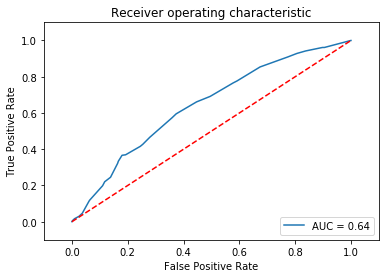

In [134]:
# ROC and AUC
from sklearn.metrics import roc_curve, auc

# Get predicted scores Pr(y=1): Used as thresholds for calculating TP Rate and FP Rate
score = decision_tree_model.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, score) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [135]:
# Plot the decision tree
# Remember you should install package graphviz first
import graphviz

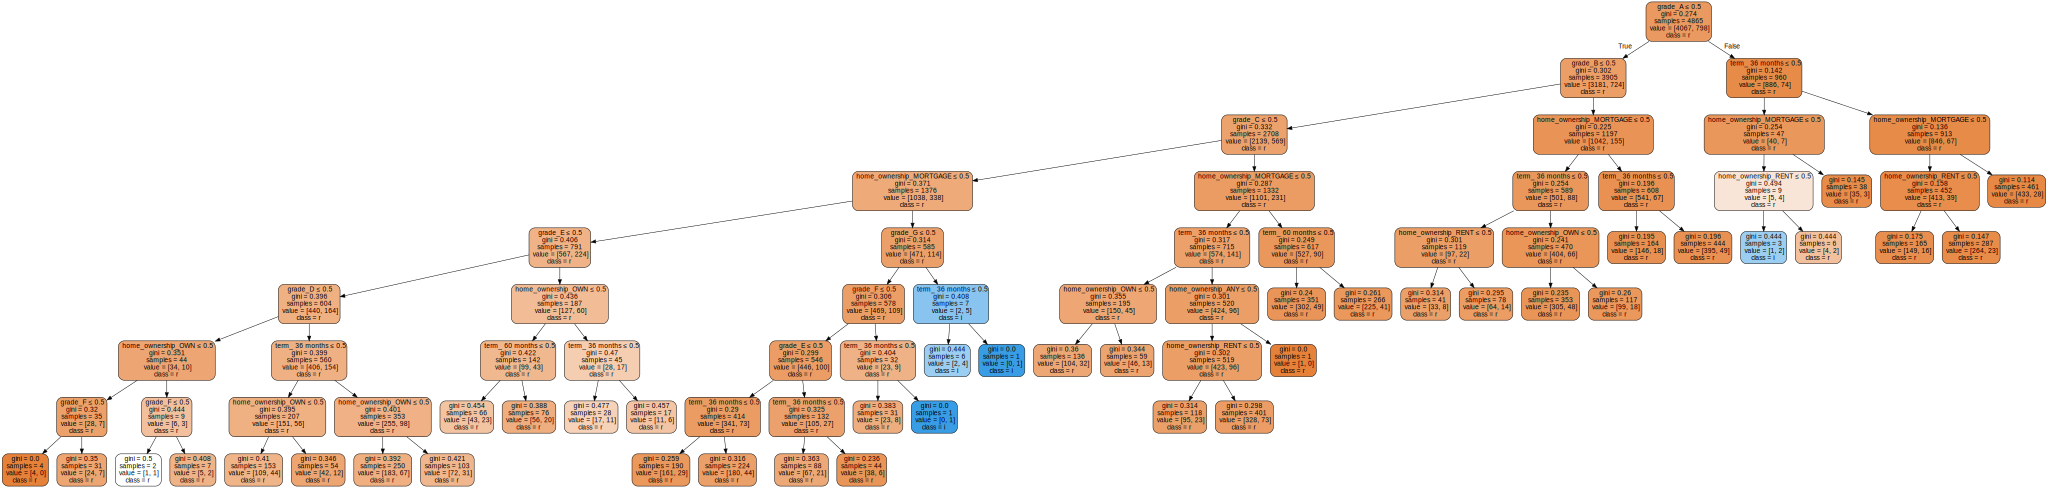

In [57]:
dot_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=features, class_names=output, 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [136]:
# Store in .pdf 
graph.render("Lending Club Loan Status") 

'Lending Club Loan Status.pdf'

#### Assignments: 
* Use Titanic data (“train.csv”); Fit the model using `scikit-learn` with different metrics (e.g., information gain, gini index)
* Observe and report the differences (e.g., best features for splitting, tree structure, performance, etc.)
* There are no right or wrong answers. Don't worry. Just report what you've seen. 

**Note:** You may need to do simple data cleaning by yourself, such as binarizing output variable "survived", and transforming categorical variables to dummy variables.

[[3 1]
 [0 5]]
3 1 0 5
Accuracy:  0.8888888888888888
Sensitivity:  1.0
Precision:  0.8333333333333334


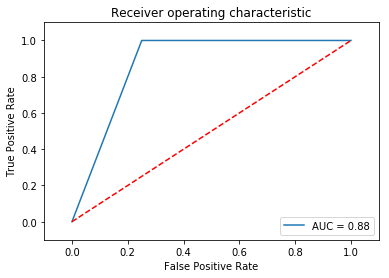

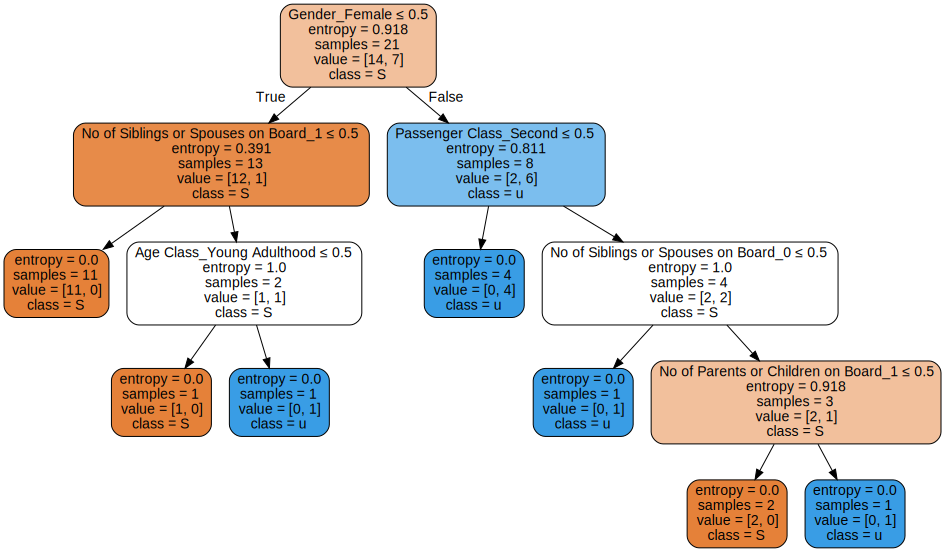

In [59]:
# Read the data from the csv documenter
titanic_data = pd.read_csv("train.csv", low_memory=False)
titanic_data.head()
titanic_data.shape
titanic_data.describe()
titanic_data["Survived"].value_counts()

# Remove unnecessary columns
titanic_data.drop(titanic_data.columns[0:2], axis=1, inplace=True)

# Binarizing output variable
titanic_data["Survived"] = titanic_data["Survived"].map(lambda x:1 if x == "Yes" else 0)

# Transform categorical features to binary features
titanic_data = pd.get_dummies(titanic_data)

# Obtain Features and Output Columns
features = list(titanic_data.columns[1:])
output = titanic_data.columns[0]

# Split dataset to do validation
X = titanic_data[features]
y = titanic_data[output]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model on train data
decision_tree = DecisionTreeClassifier(criterion="entropy")
decision_tree_model = decision_tree.fit(X_train, y_train)
decision_tree_model.classes_

# Get predicted labels for test data
y_pred = decision_tree_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

# Performance of decision tree model
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Sensitivity: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))

# ROC and AUC
from sklearn.metrics import roc_curve, auc

# Get predicted scores Pr(y=1): Used as thresholds for calculating TP Rate and FP Rate
score = decision_tree_model.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, score) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

dot_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=features, class_names=output, 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## 5 Questions (Just think about them)

### 5.1 What if features are continuous?

* Please refer to text book chapter 8 pp.93

### 5.2 What if output is continuous? 

* Regression Tree

### 5.1 What if features are continuous? Explain in words what would happen
If the features are continuous, we will not be able to effectively use decision trees, as they are more suitable for dealing with categorical variables. Some alternatives would be to either use the nearest neighbour classification, regression methods, or neural nets (e.g. for time series). On the other hand, if we want to still use decision trees, we would need to discretize the continuous attributes. 

One way to do this would be to assign buckets (e.g. weights from 0-10, 10-20 etc…). This falls under global discretization, and the resultant categorical variable can be treated as a new label regardless of the choice of our data mining algorithm. However, one drawback of this is that the data loses its meaning and out predictions are the buckets instead of the actual values.

Another way to still carry out decision tree classification would be to perform local discretisation, an example of which is rounding off to the nearest integer. Although this can increase the accuracy of the predictions, it introduces too many features and can lead to eventual overfitting.


### 5.1 What if output is continuous? Explain in words what would happen
If the output is continuous, then one solution would be to build a regression tree. In this process, we choose a predictor and a cutpoint, and partition the space such that the loss is minimized. A simple way to measure loss is to calculate the residual sum of squares (RSS). 

After obtaining this predictor and cutpoint, we recursively perform binary splitting on one of the 2 spaces and stop when some pre-defined termination condition is satisfied.


## 6 References

[1] Jason Brownlee, 2018, [Machine Learning Algorithms from Scratch with Python](https://machinelearningmastery.com/machine-learning-algorithms-from-scratch/). <br/>
[2] Peter Harrington, 2012. Machine Learning in Action. Shelter Island, NY: Manning Publications Co.